# Amazon Food Review

The objective of this notebook is to identify whether the review given by the customer is positive or negative. K-Nearest Neighbor along with Natural Language processing is used to identify the text.

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

In [ ]:
# The 'Pandas' package is a fast, flexible tool used to analyze data. It helps in reading and updating the files like csv files, excel, etc.
import pandas as pd

# NumPy is used to deal with matrix
import numpy as np

In [ ]:
# Reading the csv file, when reading a large dataset there are some bad lines which are using on_bad_lines = 'skip' skipped
# If on_bad_lines = 'warn' then a warning is given for the bad line

data = pd.read_csv('Reviews.csv', engine='python', on_bad_lines='skip')

In [ ]:
data.shape                                                                      # Returns the shape of data

(302959, 10)

In [ ]:
def convert(x):
  if x<3:
    return 0                                                                    # 0 for negative review

  return 1                                                                      # 1 for positive review

actualscore = data['Score']
posneg = actualscore.map(convert)                                               # map() function executes a specified function for each item in an iterable and returns the results
data['Score'] = posneg
print(data.shape)
data.head()

(302959, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data cleaning

In [ ]:
sort_data = data.sort_values('ProductId', axis=0, kind='quicksort', na_position='last')                           # by default sorted in ascending order NaN position first or last
final = sort_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep='first', inplace=False)     # by default false inplace says whether to modify dataset despite of creating new one
final.shape

(234491, 10)

In [ ]:
(final['Id'].size*1.0)/(data['Id'].size*1.0)*100                                # Percentage of data left after pre-processing

77.40024227700778

In [ ]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]         # Practically HelpfulnessDenominator can't be less than HelpfulnessNumerator

In [ ]:
print(final.shape)

final['Score'].value_counts()                                                   # Count of each positive and negative review

(234489, 10)


1    200273
0     34216
Name: Score, dtype: int64

# Text Pre-processing

In [ ]:
# A regular expression (or RE) specifies a set of strings that matches it.
# The module has functions in this module that let you check if a particular string matches a given regular expression or string.
import re

# Beautifulsoup is a HTML parser. It is a python package used for parsing both HTML and XML documents.
# It creates parse tree for parsed pages that can be used to extract data from HTML documents very easily which can further be used for web scraping.
from bs4 import BeautifulSoup

# tqdm for printing status bar
from tqdm import tqdm

In [ ]:
# Function returns dialect of the contractions

def decontracted(text):
  text = re.sub(r"won't", 'will not', text)
  text = re.sub(r"can\'t", 'can not', text)

  text = re.sub(r"n\'t", "not", text)
  text = re.sub(r"\'re", "are", text)
  text = re.sub(r"\'s", "is", text)
  text = re.sub(r"\'d", "would", text)
  text = re.sub(r"\'ll", "will", text)
  text = re.sub(r"\'t", "not", text)
  text = re.sub(r"\'ve", "have", text)
  text = re.sub(r"\'m", "am", text)

  return text

In [ ]:
# not, no, nor removed from stopwords becausee removing them can change the meaning of sentance(It can convert a negative review to a positive one)

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
preprocessed_reviews = []

for sentance in tqdm(final['Text'].values):                                # .values returns the list containing each row as one element
  sentance = re.sub(r"http\S+","",str(sentance))                           # Remove urls
  sentance = BeautifulSoup(sentance, 'lxml').get_text()                    # lxml is a python library for processing xml and html documents. get_text gives the text removing all tags
  sentance = decontracted(sentance)
  sentance = re.sub('\S*\d\S*',"", sentance).strip()                       # remove words with numbers \S means all the [A-Za-z] \d means [0-9]
  sentance = re.sub('[^A-Za-z]+'," ",sentance)                             # remove all special characters
  k = sentance.split()
  sentance = ' '.join(e.lower() for e in k if e.lower() not in stopwords)  # .lower() converts the aplhabets to lowercase
  preprocessed_reviews.append(sentance.strip())                            # strip() removes the leading and trailing whitespaces

  0%|          | 0/234489 [00:00<?, ?it/s]<ipython-input-136-2aaa80fdaaf6>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentance = BeautifulSoup(sentance, 'lxml').get_text() # lxml is a python library for processing xml and html documents. get_text gives the text removing all tags
100%|██████████| 234489/234489 [02:01<00:00, 1935.31it/s]


# Featurization

Converting word to vector

Bag of Words(BoW):

1.Removing stop words

2.Converting text to lower case

3.Stemming: converting words to base word

4.Lemmatization: Breaking the sentance into words (It is language specific)

Disadvantage: It doesn't consider the semantics i.e. meaning of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer                     # This is to convert our data from text to vector as algorithm works on vectors

count_vec = CountVectorizer()                                                   # Create object. This method also known as sparse matrix because most of its elements are 0
count_vec.fit(preprocessed_reviews)                                             # fit() learns the vocabulary dictionary from document
print("Features extracted:", count_vec.get_feature_names_out()[10:20])

vector = count_vec.transform(preprocessed_reviews)                              # transform() transform the vocubulary to matrix
print("Shape of BOW vectorizer:", vector.get_shape())
# Row = vector for each review
# Column = vector containing frequency count of each word
print("Number of unique words:", vector.get_shape()[1])

Features extracted: ['aaaaaahhhhhyaaaaaa' 'aaaaaawwwwwwwwww' 'aaaaah' 'aaaaallll' 'aaaaawsome'
 'aaaah' 'aaaahhhhhh' 'aaaallll' 'aaaand' 'aaah']
Shape of BOW vectorizer: (234489, 96798)
Number of unique words: 96798


Bi-grams and n-gram

In [ ]:
# ngram_range=(1,2) create unigram and bigrams both if (2,2) then only consider bigrams
# min_df = 10 implies ignore the words having count less than 10
# max_features implies out of thousands of words select the first n maximum occuring words

count_vec = CountVectorizer(ngram_range=(1,2), min_df = 10, max_features=5000)
vector = count_vec.fit_transform(preprocessed_reviews)                          # fit_transform() learns the vocabulary dictionary from document and transform them to matrix

print("Shape of BOW:", vector.get_shape())
print("Number of unique words including both unigrams and bigrams:", vector.get_shape()[1])

Shape of BOW: (234489, 5000)
Number of unique words including both unigrams and bigrams: 5000


TF-IDF

TF high when word frequent in document

IDF high when word rare in corpus


Doesn't consider symantic meaning

Importance given to those words which are rare in corpus

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
# ngram_range=(1,2) create unigram and bigrams both if (2,2) then only consider bigrams
# min_df = 10 implies ignore the words having count less than 10
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10)

tf_idf_vec.fit(preprocessed_reviews)                                            # fit() learns the vocabulary dictionary from document
print("Features extracted:", tf_idf_vec.get_feature_names_out()[10:20])

vector = tf_idf_vec.transform(preprocessed_reviews)                             # transform() transform the vocubulary to matrix
print("Shape of BOW:", vector.get_shape())
print("Number of unique words including both unigrams and bigrams:", vector.get_shape()[1])

Features extracted: ['abdomen' 'abdominal' 'abdominal pain' 'abide' 'abilities' 'ability'
 'ability buy' 'ability get' 'ability make' 'abit']
Shape of BOW: (234489, 141470)
Number of unique words including both unigrams and bigrams: 141470


# Model

In [ ]:
from sklearn.model_selection import train_test_split

X = preprocessed_reviews
Y = final['Score']

# Specifying the train size to 0.75 means splitting the data in 75% train data and 25% test data. It can also be done using test_size = 0.25
# Specifying the random_state means specifying the seed as row are assigned to train and test set randomly.
X_ , X_test, Y_, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 1)

# Splitting data in validation dataset and training dataset
X_train, X_cross_val, Y_train, Y_cross_val = train_test_split(X_, Y_, test_size=0.3, random_state =1)

In [ ]:
count_vect = CountVectorizer()
vector_train = count_vect.fit_transform(X_train)
vector_cross_val = count_vect.transform(X_cross_val)
vector_test = count_vect.transform(X_test)

In [ ]:
# finding best value of k

from sklearn.neighbors import KNeighborsClassifier

# ROC stands for Receiver Operating Characteristic is a probability curve and AUC stands for area under the curve.
# It tells how much the model is capable of distinguishing between classes.
from sklearn.metrics import roc_auc_score

roc_train = []
roc_cross_val = []
k_value = []
max_auc_roc_score = 0
k_best = 0

for k in range(1,100,4):
  # knn support several algorithms which include brute force, kd-tree, ball tree, etc.
  # n-neighbors is the number of neighbors to be considered
  knn = KNeighborsClassifier(algorithm = "brute", metric = "euclidean", n_neighbors = k)   # by default metric is minkowski with p = 2 means euclidean

  knn.fit(vector_train, Y_train)

  pred_cross_val = knn.predict_proba(vector_cross_val)                          # Return probablities of each classification label in the form of nd-array (prob(0), prob(1))
                                                                                # that is probability of occurring and not occurring of each label
  pred_cross_val = (pred_cross_val)[:,1]                                        # Extracted predicted prob(1)

  k_value.append(k)
  roc_cross_val.append(roc_auc_score(Y_cross_val, pred_cross_val))

  # roc_auc_score is the area under the curve. It uses probability because roc is a probabilty curve
  if roc_auc_score(Y_cross_val, pred_cross_val) > max_auc_roc_score:            # Finding k value with maximum area under the curve, more the area more is the accuracy of model
    k_best = k
    max_auc_roc_score = roc_auc_score(Y_cross_val, pred_cross_val)

print("Best k value:", k_best)
print("Maximum area under the curve:", max_auc_roc_score)

Best k value: 25
Maximum area under the curve: 0.6752625675522954


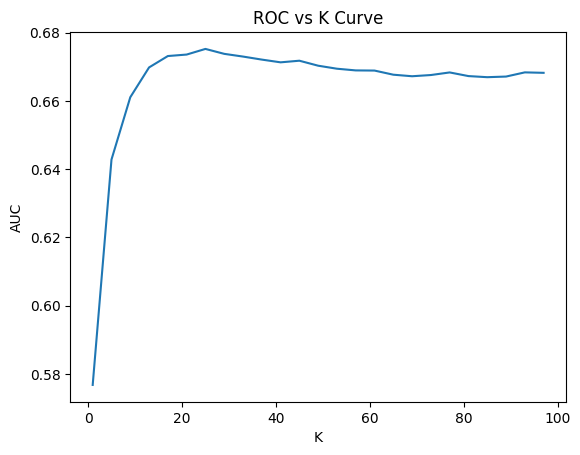

In [ ]:
import matplotlib.pyplot as plt

plt.plot(k_value, roc_cross_val)
plt.title("ROC vs K Curve")                # Note: It is AUC vs K curve
plt.xlabel("K")
plt.ylabel("AUC")
plt.show()

In [ ]:
knn = KNeighborsClassifier(algorithm = "brute", metric = "euclidean", n_neighbors = k_best)
knn.fit(vector_train, Y_train)

pred_test = knn.predict_proba(vector_test)
pred_test = (pred_test)[:,1]

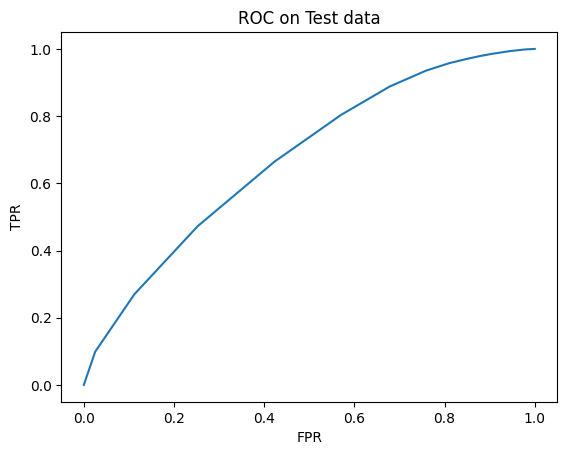

In [ ]:
# Plotting the roc curve

from sklearn import metrics

# FPR = False Positive Rate
# TPR = True Positive Rate
fpr, tpr, threshold = metrics.roc_curve(Y_test, pred_test)

plt.plot(fpr, tpr)
plt.title("ROC on Test data")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Accuracy: 0.858188693192318


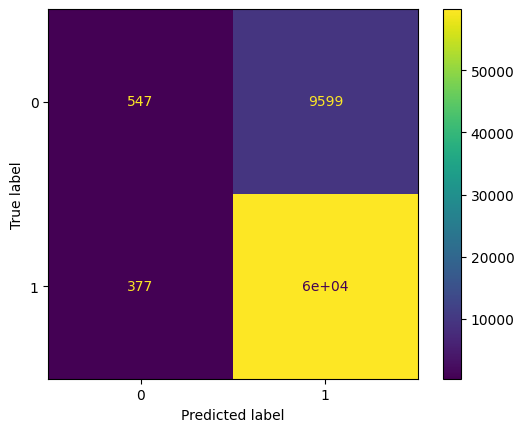

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred = knn.predict(vector_test)                                               # predict() function predicts the 0 1 label of class
print("Accuracy:", accuracy_score(Y_test, y_pred))

matrix = confusion_matrix(Y_test, y_pred)                                       # It creates the confusion matrix
cf = ConfusionMatrixDisplay(matrix, display_labels = [0, 1])                    # It displays the confusion matrix
cf.plot()

In the result most of the samples are classified as positive because the data biased. It has more positive points hence, more of points has its nearest neighbor as positive point.

# Applying KD tree on tf-idf

KDTree is a space partitioning data structure for organizing points in K-Dimensional space. All the partitions are axis parallel. It constructs a tree and it is quite similar to binary search tree.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

X = preprocessed_reviews[:30000]
Y = final['Score'][:30000]

# Specifying the train size to 0.75 means splitting the data in 75% train data and 25% test data. It can also be done using test_size = 0.25
# Specifying the random_state means specifying the seed as row are assigned to train and test set randomly.
X_ , X_test, Y_, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 1)

# Splitting data in validation dataset and training dataset
X_train, X_cross_val, Y_train, Y_cross_val = train_test_split(X_, Y_, test_size=0.3, random_state =1)

tfidf_vec = TfidfVectorizer(ngram_range = (1,2), min_df = 10)
vector_train = tfidf_vec.fit_transform(X_train)
vector_cross_val = tfidf_vec.transform(X_cross_val)
vector_test = tfidf_vec.transform(X_test)

In [ ]:
# kd-tree doesn't work on sparse matrix(i.e. matrix in which maximum element has value equal to zero)
# It works on dense matrix here toarray() function is used to convert it to dense matrix that is even storing the data with zero value
vector_train = vector_train.toarray()
vector_cross_val = vector_cross_val.toarray()
vector_test = vector_test.toarray()

In [ ]:
# Finding best value of k

from sklearn.neighbors import KNeighborsClassifier

# ROC stands for Receiver Operating Characteristic is a probability curve and AUC stands for area under the curve.
# It tells how much the model is capable of distinguishing between classes.
from sklearn.metrics import roc_auc_score

roc_train = []
roc_cross_val = []
k_value = []
max_auc_roc_score = 0
k_best = 0

for k in tqdm(range(1,100,20)):
  knn = KNeighborsClassifier(algorithm = "kd_tree", metric = "euclidean", n_neighbors = k)            # by default minkowski with p = 2 means euclidean

  knn.fit(vector_train, Y_train)

  pred_cross_val = knn.predict_proba(vector_cross_val)                          # Return probablities of each classification label in the form of nd-array (prob(0), prob(1))
                                                                                #  that is probability of occurring and not occurring of each label
  pred_cross_val = (pred_cross_val)[:,1]                                        # Extracted predicted prob(1)

  k_value.append(k)
  roc_cross_val.append(roc_auc_score(Y_cross_val, pred_cross_val))

  # roc_auc_score is the area under the curve. It uses probability because roc is a probabilty curve
  if roc_auc_score(Y_cross_val, pred_cross_val) > max_auc_roc_score:            # Finding k value with maximum area under the curve, more the area more is the accuracy of model
    k_best = k
    max_auc_roc_score = roc_auc_score(Y_cross_val, pred_cross_val)

print("\nBest k value:", k_best)
print("Maximum area under the curve:", max_auc_roc_score)

100%|██████████| 5/5 [2:27:38<00:00, 1771.61s/it]


Best k value: 81
Maximum area under the curve: 0.8412132316133036


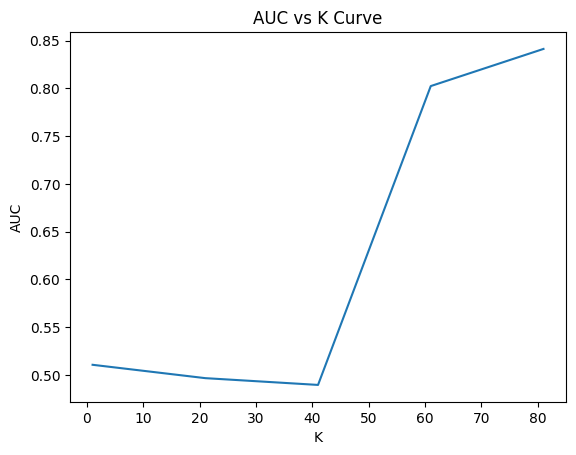

In [ ]:
import matplotlib.pyplot as plt

plt.plot(k_value, roc_cross_val)
plt.title("AUC vs K Curve")
plt.xlabel("K")
plt.ylabel("AUC")
plt.show()

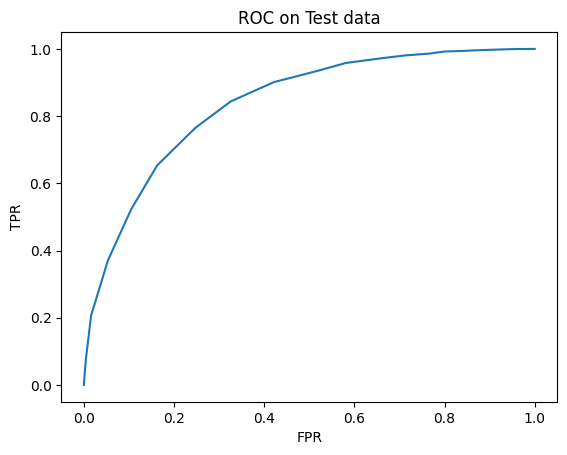

In [ ]:
# Plotting the roc curve

from sklearn import metrics

knn = KNeighborsClassifier(algorithm = "kd_tree", metric = "euclidean", n_neighbors = k_best)
knn.fit(vector_train, Y_train)

pred_test = knn.predict_proba(vector_test)
pred_test = (pred_test)[:,1]

# FPR = False Positive Rate
# TPR = True Positive Rate
fpr, tpr, threshold = metrics.roc_curve(Y_test, pred_test)

plt.plot(fpr, tpr)
plt.title("ROC on Test data")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Accuracy: 0.8498888888888889


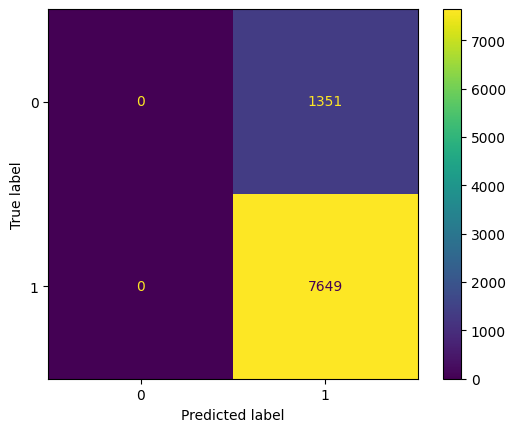

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred = knn.predict(vector_test)                                               # predict() function predicts the 0 1 label of class
print("Accuracy:", accuracy_score(Y_test, y_pred))

matrix = confusion_matrix(Y_test, y_pred)                                       # It creates the confusion matrix
cf = ConfusionMatrixDisplay(matrix, display_labels = [0, 1])                    # It displays the confusion matrix
cf.plot()

In the result most of the samples are classified as positive because the data biased. It has more positive points hence, more of points has its nearest neighbor as positive point. Possible solution is to do sampling and remove bias.